## SDS 2020 - Module 3: Individual Assignment 

In [ ]:
Assignment
toc:true
branch: master
badges: true
comments: true
categories: [fastpages, jupyter]

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

## Data and preprocessing

In [2]:
# Loading up data
tweets = pd.read_json("https://github.com/SDS-AAU/SDS-master/raw/e2c959494d53859c1844604bed09a28a21566d0f/M3/assignments/trump_vs_GPT2.gz")

In [3]:
# Adding columnnames to the dataframe
tweets.columns = ["text", "status"]

In [4]:
# Tranforming from boolean to integer - for the neural net
tweets['status'].astype(int)

0        1
1        1
2        1
3        1
4        1
        ..
14731    0
14732    0
14733    0
14734    0
14735    0
Name: status, Length: 14736, dtype: int64

In [5]:
# I want to see the length of the tweets to check for outliers
length = []
[length.append(len(str(text))) for text in tweets['text']]
tweets['length'] = length
tweets.head()

,text,status,length
0,I was thrilled to be back in the Great city of...,True,210
1,The Unsolicited Mail In Ballot Scam is a major...,True,100
2,"As long as I am President, I will always stand...",True,82
3,"Our Economy is doing great, and is ready to se...",True,81
4,If I do not sound like a typical Washington po...,True,90


In [6]:
# Seems like i have to remove some since the min value is 0
print(min(tweets['length']))
print(max(tweets['length']))
print(round(sum(tweets['length'])/len(tweets['length'])))

0
296
163


In [7]:
# 408 tweets with a length under 10 words
# I'm choosing this since i want a full sentence and not just single words
len(tweets[tweets['length'] < 10])

408

In [8]:
# Keeping all rows with a length over or equal to 10 words
tweets = tweets[tweets.length >= 10]

In [9]:
# Instantiating of the tokenizer setting oov_token to True 
# any unknown words will be replaced
# Also removing punctuation by default
tokenizer = Tokenizer(lower=True, oov_token=True)

In [10]:
# Defining my dependent and independent variable
# I want to predict the status 0 or 1, so that will be the dependent variable
X = tweets['text']
y = tweets['status']

In [11]:
# Making the train test split for the model
# Picking a test size of 0.3 - tried to adjust it, but result didn't get better
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# Fitting the tokenizer on the training data 
tokenizer.fit_on_texts(X_train)

In [13]:
# I have to fit the tokenizer on the data before i can get the vocab size
# Here i have the size for the input_dim in the Embedding layer
max_vocab = len(tokenizer.word_index)+1

In [14]:
# And then turning words into numbers/sequences for the neural net
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [15]:
# Furthermore padding the sequences to give them the same length 
# This is required when giving input to the neural net
data_train = pad_sequences(sequences_train)
data_test = pad_sequences(sequences_test, maxlen=data_train.shape[1])

## Building the model

In [16]:
# Using a Sequential model which can process sequences of integers which is what i got
model = keras.Sequential()

In [17]:
# Adding an Embedding layer to compress the input
# Where the input size is equal to the vocabulary size + 1
# Keeping a small number for output since it gave the best results
model.add(layers.Embedding(max_vocab, 16))

In [18]:
# Adding BidirectionalLSTM layer because i want the model to read both back and forth
# Where the normal LSTM model only reads from left to right
# So this one should give a better result than the normal one
# Also adding Dropout of 0.9 since i found that the model performed better with this
model.add(layers.Bidirectional(layers.LSTM(8, return_sequences=True, dropout=0.9)))

In [19]:
# Output layer with sigmoid activation function
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
# We can see there is 211.537 trainable parameters 
# I found that when trying with over 1 million parameters the model gets overfitted real quick
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          209920    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 16)          1600      
_________________________________________________________________
dense (Dense)                (None, None, 1)           17        
Total params: 211,537
Trainable params: 211,537
Non-trainable params: 0
_________________________________________________________________


## Training and evaluation of the model

In [21]:
# Using binary_crossentropy since there are only two label classes 0 and 1
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
# I found that the number of epochs fits on 6 and also batch size of 64
# I have tried many different setups, and in many cases i ended up overfitting the training set
r = model.fit(data_train, y_train, epochs=6, validation_data=(data_test, y_test), batch_size=64)

Epoch 1/6
157/157 [==============================] - 3s 19ms/step - loss: 0.6148 - accuracy: 0.6818 - val_loss: 0.4837 - val_accuracy: 0.8163
Epoch 2/6
157/157 [==============================] - 2s 15ms/step - loss: 0.4795 - accuracy: 0.8043 - val_loss: 0.4379 - val_accuracy: 0.8270
Epoch 3/6
157/157 [==============================] - 2s 15ms/step - loss: 0.4384 - accuracy: 0.8196 - val_loss: 0.3953 - val_accuracy: 0.8462
Epoch 4/6
157/157 [==============================] - 2s 15ms/step - loss: 0.4003 - accuracy: 0.8390 - val_loss: 0.3772 - val_accuracy: 0.8491
Epoch 5/6
157/157 [==============================] - 2s 15ms/step - loss: 0.3732 - accuracy: 0.8518 - val_loss: 0.3602 - val_accuracy: 0.8547
Epoch 6/6
157/157 [==============================] - 2s 15ms/step - loss: 0.3514 - accuracy: 0.8588 - val_loss: 0.3466 - val_accuracy: 0.8591


I can see here that the loss score is decreasing for both the training and test set in each epoch as well as the accuracy is increasing which is the goal for this step here where i want to achieve a low loss and a high accuracy meaning that the model is as precise as it can be. 
The reason why i didn't choose more epochs is because the training set starts to get overfitted from here. PLEASE BE AWARE THAT THE val_accuracy IS FOUND UNDER THE 'Epoch 1/6 157/157'.

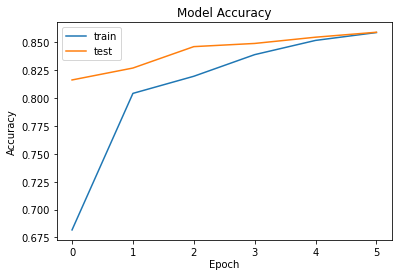

In [23]:
# Now i want to compare the train and test results in the following two graphs
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch', labelpad=2)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

From this i can see that both the train and test set is improving over the 6 epochs and then ending up being approximately the same in the last epoch. (0, 1, 2, 3, 4, 5 - so six)

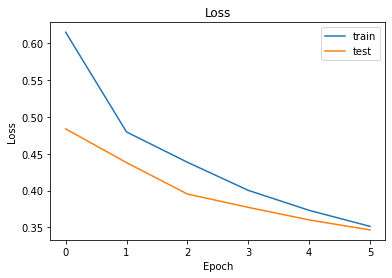

In [24]:
# Taking a look at the loss score here
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

The same is the case for the loss score, where the graphs are almost meeting each other in the 6th epoch which means that it is the near perfect fit. 

I had a lot of trouble finding a good match, where in many cases the model ended up being overfit - being that the training set was improving really quick ending on 0.98 on the accuracy score but with high loss score on the validation set - which should be as low as possible. 
I have both tried adding more layers to the model and also adjusting the number of neurons in the layers, but i found that keeping the model on few layers with few neurons and a high dropout rate gave me the best performing neural net. 


So this means that the model will be able to detect a fake tweet with an accuracy of 86%.

In [ ]:
!jupyter nbconvert --to html "/content/M3A1.ipynb"